## NFL Picks

NFL match prediction with scores using historical data (1999-Present).

### Import Required Packages

In [24]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Packages imported successfully!")

Packages imported successfully!


### Load Historical NFL Data

In [25]:
# Load historical data from 1999 to present
print("Loading NFL historical data from 1999 to present...")

# Get years from 1999 to current year
current_year = pd.Timestamp.now().year
years = list(range(1999, current_year + 1))

# Load play-by-play data (this might take a few minutes)
pbp_data = nfl.import_pbp_data(years)
print(f"Loaded play-by-play data: {pbp_data.shape}")

# Load schedule data
schedules = nfl.import_schedules(years)
print(f"Loaded schedules: {schedules.shape}")

# We'll derive team stats from the play-by-play and schedule data
print("Data loading complete!")

Loading NFL historical data from 1999 to present...
1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
2025 done.
Downcasting floats.
Loaded play-by-play data: (1266757, 398)
Loaded schedules: (7263, 46)
Data loading complete!


### Data Exploration and Understanding

In [26]:
# Explore the structure of our datasets
print("=== SCHEDULE DATA SAMPLE ===")
print(schedules.head())
print("\nSchedule columns:", schedules.columns.tolist())

print("\n=== PLAY BY PLAY SAMPLE ===")
print(pbp_data.head())
print(f"\nPBP columns count: {len(pbp_data.columns)}")

# Check for missing scores
print(f"\nGames with missing scores: {schedules[['home_score', 'away_score']].isnull().sum()}")

# Look at score distributions
completed_games = schedules.dropna(subset=['home_score', 'away_score'])
print(f"\nCompleted games: {len(completed_games)}")
print(f"Average home score: {completed_games['home_score'].mean():.1f}")
print(f"Average away score: {completed_games['away_score'].mean():.1f}")
print(f"Average total score: {(completed_games['home_score'] + completed_games['away_score']).mean():.1f}")

=== SCHEDULE DATA SAMPLE ===
           game_id  season game_type  week     gameday weekday gametime  \
0  1999_01_MIN_ATL    1999       REG     1  1999-09-12  Sunday      NaN   
1   1999_01_KC_CHI    1999       REG     1  1999-09-12  Sunday      NaN   
2  1999_01_PIT_CLE    1999       REG     1  1999-09-12  Sunday      NaN   
3   1999_01_OAK_GB    1999       REG     1  1999-09-12  Sunday      NaN   
4  1999_01_BUF_IND    1999       REG     1  1999-09-12  Sunday      NaN   

  away_team  away_score home_team  ...  wind  away_qb_id  home_qb_id  \
0       MIN        17.0       ATL  ...   NaN  00-0003761  00-0002876   
1        KC        17.0       CHI  ...  12.0  00-0006300  00-0010560   
2       PIT        43.0       CLE  ...  12.0  00-0015700  00-0004230   
3       OAK        24.0        GB  ...  10.0  00-0005741  00-0005106   
4       BUF        14.0       IND  ...   NaN  00-0005363  00-0010346   

         away_qb_name    home_qb_name          away_coach    home_coach  \
0  Randall C

### Create Team Performance Features

In [27]:
def create_team_performance_features(schedules, pbp_data):
    """
    Create advanced team performance features with rolling averages and recent form
    """
    print("Creating advanced team performance features...")
    
    # Filter regular season games with valid scores
    games = schedules[(schedules['game_type'] == 'REG') & 
                     (schedules['home_score'].notna()) & 
                     (schedules['away_score'].notna())].copy()
    
    team_stats = []
    
    for team in games['home_team'].unique():
        # Home games
        home_games = games[games['home_team'] == team].copy()
        home_games['team'] = team
        home_games['opponent'] = home_games['away_team']
        home_games['points_scored'] = home_games['home_score']
        home_games['points_allowed'] = home_games['away_score']
        home_games['is_home'] = 1
        home_games['won'] = (home_games['home_score'] > home_games['away_score']).astype(int)
        
        # Away games
        away_games = games[games['away_team'] == team].copy()
        away_games['team'] = team
        away_games['opponent'] = away_games['home_team']
        away_games['points_scored'] = away_games['away_score']
        away_games['points_allowed'] = away_games['home_score']
        away_games['is_home'] = 0
        away_games['won'] = (away_games['away_score'] > away_games['home_score']).astype(int)
        
        # Combine and sort chronologically
        team_games = pd.concat([home_games, away_games])
        team_games = team_games.sort_values(['season', 'week']).reset_index(drop=True)
        
        # Calculate rolling averages with multiple windows
        for window in [3, 5, 10]:
            team_games[f'points_scored_L{window}'] = team_games['points_scored'].rolling(window=window, min_periods=1).mean()
            team_games[f'points_allowed_L{window}'] = team_games['points_allowed'].rolling(window=window, min_periods=1).mean()
            team_games[f'point_diff_L{window}'] = team_games[f'points_scored_L{window}'] - team_games[f'points_allowed_L{window}']
            team_games[f'win_pct_L{window}'] = team_games['won'].rolling(window=window, min_periods=1).mean()
        
        # Exponential moving average (gives more weight to recent games)
        team_games['points_scored_EMA'] = team_games['points_scored'].ewm(span=5, adjust=False).mean()
        team_games['points_allowed_EMA'] = team_games['points_allowed'].ewm(span=5, adjust=False).mean()
        
        # Season-to-date statistics
        team_games['season_points_avg'] = team_games.groupby('season')['points_scored'].expanding().mean().reset_index(level=0, drop=True)
        team_games['season_allowed_avg'] = team_games.groupby('season')['points_allowed'].expanding().mean().reset_index(level=0, drop=True)
        team_games['season_wins'] = team_games.groupby('season')['won'].expanding().sum().reset_index(level=0, drop=True)
        team_games['season_games'] = team_games.groupby('season').cumcount() + 1
        team_games['season_win_pct'] = team_games['season_wins'] / team_games['season_games']
        
        # Home/away splits
        team_games['home_points_avg'] = team_games[team_games['is_home'] == 1].groupby('season')['points_scored'].expanding().mean().reset_index(level=0, drop=True)
        team_games['away_points_avg'] = team_games[team_games['is_home'] == 0].groupby('season')['points_scored'].expanding().mean().reset_index(level=0, drop=True)
        team_games['home_points_avg'] = team_games['home_points_avg'].fillna(team_games['season_points_avg'])
        team_games['away_points_avg'] = team_games['away_points_avg'].fillna(team_games['season_points_avg'])
        
        # Recent form indicators
        team_games['last_3_wins'] = team_games['won'].rolling(window=3, min_periods=1).sum()
        team_games['last_5_wins'] = team_games['won'].rolling(window=5, min_periods=1).sum()
        team_games['momentum'] = team_games['point_diff_L3'] - team_games['point_diff_L10']
        
        # Offensive and defensive efficiency
        team_games['off_efficiency'] = team_games['points_scored_L5'] / team_games['season_points_avg'].replace(0, 1)
        team_games['def_efficiency'] = team_games['points_allowed_L5'] / team_games['season_allowed_avg'].replace(0, 1)
        
        # Consistency metrics
        team_games['points_scored_std'] = team_games['points_scored'].rolling(window=5, min_periods=2).std()
        team_games['consistency_score'] = 1 / (1 + team_games['points_scored_std'].fillna(10))
        
        team_stats.append(team_games)
    
    # Combine all team statistics
    all_team_stats = pd.concat(team_stats, ignore_index=True)
    
    print(f"Created performance features for {len(all_team_stats)} team-game records")
    print(f"Feature columns: {len(all_team_stats.columns)}")
    
    return all_team_stats

### Merge Features with Game Data

In [28]:
def merge_features_with_games(schedules, team_stats):
    """
    Merge team performance features with game schedule data for both home and away teams
    """
    print("Merging team features with game data...")
    
    # Filter regular season games
    games = schedules[(schedules['game_type'] == 'REG') & 
                     (schedules['home_score'].notna()) & 
                     (schedules['away_score'].notna())].copy()
    
    # Store original columns to preserve
    original_cols = games.columns.tolist()
    
    # Create lagged features (use stats from games BEFORE current game)
    team_stats_lagged = team_stats.copy()
    team_stats_lagged['next_season'] = team_stats_lagged['season']
    team_stats_lagged['next_week'] = team_stats_lagged['week'] + 1
    
    # Handle week rollover between seasons
    max_week = team_stats_lagged.groupby('season')['week'].max()
    for season in max_week.index:
        mask = (team_stats_lagged['season'] == season) & (team_stats_lagged['next_week'] > max_week[season])
        team_stats_lagged.loc[mask, 'next_season'] = season + 1
        team_stats_lagged.loc[mask, 'next_week'] = 1
    
    # Select feature columns to merge
    feature_cols = [col for col in team_stats_lagged.columns if any(x in col for x in 
                   ['_L3', '_L5', '_L10', '_EMA', 'season_', 'home_', 'away_', 
                    'last_', 'momentum', 'efficiency', 'consistency', 'point_diff'])]
    
    merge_cols = ['team', 'next_season', 'next_week'] + feature_cols
    team_features = team_stats_lagged[merge_cols].copy()
    
    # Merge home team features
    home_features = team_features.copy()
    for col in feature_cols:
        home_features.rename(columns={col: f'home_{col}'}, inplace=True)
    
    games = games.merge(
        home_features,
        left_on=['home_team', 'season', 'week'],
        right_on=['team', 'next_season', 'next_week'],
        how='left'
    )
    
    # Drop merge helper columns
    games.drop(columns=['team', 'next_season', 'next_week'], inplace=True, errors='ignore')
    
    # Merge away team features
    away_features = team_features.copy()
    for col in feature_cols:
        away_features.rename(columns={col: f'away_{col}'}, inplace=True)
    
    games = games.merge(
        away_features,
        left_on=['away_team', 'season', 'week'],
        right_on=['team', 'next_season', 'next_week'],
        how='left'
    )
    
    # Drop merge helper columns
    games.drop(columns=['team', 'next_season', 'next_week'], inplace=True, errors='ignore')
    
    # Verify critical columns exist
    if 'home_team' not in games.columns or 'away_team' not in games.columns:
        raise ValueError("Critical columns (home_team, away_team) missing after merge")
    
    # Remove rows with missing features
    home_feature_check = f'home_{feature_cols[0]}'
    away_feature_check = f'away_{feature_cols[0]}'
    
    initial_count = len(games)
    
    if home_feature_check in games.columns and away_feature_check in games.columns:
        games = games.dropna(subset=[home_feature_check, away_feature_check])
    
    final_count = len(games)
    
    print(f"Merged features: {initial_count} games → {final_count} games with complete features")
    print(f"Total feature columns: {len(games.columns)}")
    
    return games

### Feature Engineering and Data Preparation

In [29]:
def prepare_features_and_target(games_with_features):
    """
    Prepare feature matrix and target variables with advanced feature engineering
    """
    print("Preparing features and targets...")
    
    # Create relative/differential features
    features_df = games_with_features.copy()
    
    # Direct matchup features
    for window in [3, 5, 10]:
        features_df[f'points_diff_L{window}'] = features_df[f'home_points_scored_L{window}'] - features_df[f'away_points_scored_L{window}']
        features_df[f'defense_diff_L{window}'] = features_df[f'away_points_allowed_L{window}'] - features_df[f'home_points_allowed_L{window}']
        features_df[f'form_diff_L{window}'] = features_df[f'home_win_pct_L{window}'] - features_df[f'away_win_pct_L{window}']
        features_df[f'point_diff_advantage_L{window}'] = features_df[f'home_point_diff_L{window}'] - features_df[f'away_point_diff_L{window}']
    
    # EMA differentials
    features_df['points_diff_EMA'] = features_df['home_points_scored_EMA'] - features_df['away_points_scored_EMA']
    features_df['defense_diff_EMA'] = features_df['away_points_allowed_EMA'] - features_df['home_points_allowed_EMA']
    
    # Season performance differentials
    features_df['season_win_pct_diff'] = features_df['home_season_win_pct'] - features_df['away_season_win_pct']
    features_df['season_points_diff'] = features_df['home_season_points_avg'] - features_df['away_season_points_avg']
    
    # Home field advantage indicators
    features_df['home_advantage'] = features_df['home_home_points_avg'] - features_df['away_away_points_avg']
    
    # Momentum and form indicators
    features_df['momentum_diff'] = features_df['home_momentum'] - features_df['away_momentum']
    features_df['recent_form_diff'] = features_df['home_last_5_wins'] - features_df['away_last_5_wins']
    
    # Efficiency differentials
    features_df['off_efficiency_diff'] = features_df['home_off_efficiency'] - features_df['away_off_efficiency']
    features_df['def_efficiency_diff'] = features_df['home_def_efficiency'] - features_df['away_def_efficiency']
    
    # Consistency metrics
    features_df['consistency_diff'] = features_df['home_consistency_score'] - features_df['away_consistency_score']
    
    # Interaction features
    features_df['off_vs_def_home'] = features_df['home_points_scored_L5'] * features_df['away_points_allowed_L5']
    features_df['off_vs_def_away'] = features_df['away_points_scored_L5'] * features_df['home_points_allowed_L5']
    
    # Select feature columns
    feature_columns = [col for col in features_df.columns if any(x in col for x in 
                      ['home_points_scored_', 'away_points_scored_',
                       'home_points_allowed_', 'away_points_allowed_',
                       'home_point_diff_', 'away_point_diff_',
                       'home_win_pct_', 'away_win_pct_',
                       'home_season_', 'away_season_',
                       'home_last_', 'away_last_',
                       'home_momentum', 'away_momentum',
                       'home_off_efficiency', 'away_off_efficiency',
                       'home_def_efficiency', 'away_def_efficiency',
                       'home_consistency', 'away_consistency',
                       'home_home_points', 'away_away_points',
                       '_diff', '_advantage', 'off_vs_def'])]
    
    # Remove duplicates and sort
    feature_columns = sorted(list(set(feature_columns)))
    
    X = features_df[feature_columns].copy()
    y_home = features_df['home_score'].copy()
    y_away = features_df['away_score'].copy()
    
    # Fill any remaining NaN values
    X = X.fillna(X.mean())
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Target variables: home_score, away_score")
    print(f"Sample size: {len(X)} games")
    
    return X, y_home, y_away, feature_columns

# Execute the feature preparation pipeline
print("=== FEATURE ENGINEERING PIPELINE ===\n")

# Step 1: Create team performance features
team_stats = create_team_performance_features(schedules, pbp_data)

# Step 2: Merge features with game data
games_with_features = merge_features_with_games(schedules, team_stats)

# Step 3: Prepare final feature matrix and targets
X, y_home, y_away, feature_columns = prepare_features_and_target(games_with_features)

print(f"\n=== FEATURE ENGINEERING COMPLETE ===")
print(f"Ready for model training with {len(feature_columns)} features")

=== FEATURE ENGINEERING PIPELINE ===

Creating advanced team performance features...
Created performance features for 13808 team-game records
Feature columns: 80
Merging team features with game data...
Merged features: 6904 games → 6087 games with complete features
Total feature columns: 132
Preparing features and targets...
Feature matrix shape: (6087, 76)
Number of features: 76
Target variables: home_score, away_score
Sample size: 6087 games

=== FEATURE ENGINEERING COMPLETE ===
Ready for model training with 76 features


### Train Models for Score Prediction

In [30]:
class AdvancedNFLScorePredictor:
    """
    NFL score predictor with balanced regularisation
    """
    
    def __init__(self):
        self.home_model = None
        self.away_model = None
        self.scaler = StandardScaler()
        self.feature_columns = None
        self.feature_importance_home = None
        self.feature_importance_away = None
        self.home_baseline = 23.3
        self.away_baseline = 20.9
        
    def create_advanced_features(self, X):
        """Create high-signal matchup features"""
        X = X.copy()
        
        # Core offensive vs defensive matchups
        if all(col in X.columns for col in ['home_points_scored_L10', 'away_points_allowed_L10']):
            X['home_off_strength'] = X['home_points_scored_L10'] - 23.3
            X['away_def_weakness'] = X['away_points_allowed_L10'] - 20.9
            X['home_matchup_advantage'] = X['home_off_strength'] - X['away_def_weakness']
            
        if all(col in X.columns for col in ['away_points_scored_L10', 'home_points_allowed_L10']):
            X['away_off_strength'] = X['away_points_scored_L10'] - 20.9
            X['home_def_weakness'] = X['home_points_allowed_L10'] - 23.3
            X['away_matchup_advantage'] = X['away_off_strength'] - X['home_def_weakness']
        
        # Trend indicators
        if all(col in X.columns for col in ['home_points_scored_L5', 'home_season_points_avg']):
            X['home_trending'] = X['home_points_scored_L5'] - X['home_season_points_avg']
            X['away_trending'] = X['away_points_scored_L5'] - X['away_season_points_avg']
        
        # Momentum multipliers
        if all(col in X.columns for col in ['home_point_diff_L10', 'away_point_diff_L10']):
            X['home_momentum_squared'] = np.sign(X['home_point_diff_L10']) * (X['home_point_diff_L10'] ** 2) / 100
            X['away_momentum_squared'] = np.sign(X['away_point_diff_L10']) * (X['away_point_diff_L10'] ** 2) / 100
            X['momentum_battle'] = X['home_point_diff_L10'] * X['away_point_diff_L10'] / 100
        
        # Pace indicators
        if all(col in X.columns for col in ['home_season_points_avg', 'away_season_points_avg']):
            X['expected_total_points'] = X['home_season_points_avg'] + X['away_season_points_avg']
            X['pace_factor'] = X['expected_total_points'] / 44.2
        
        # Win probability features
        if all(col in X.columns for col in ['home_win_pct_L5', 'away_win_pct_L5']):
            X['win_pct_product'] = X['home_win_pct_L5'] * X['away_win_pct_L5']
            X['win_pct_ratio'] = (X['home_win_pct_L5'] + 0.1) / (X['away_win_pct_L5'] + 0.1)
        
        # Streak features
        if 'home_last_5_wins' in X.columns:
            X['home_on_streak'] = (X['home_last_5_wins'] >= 4).astype(int)
            X['away_on_streak'] = (X['away_last_5_wins'] >= 4).astype(int)
        
        # Defence quality ratios
        if all(col in X.columns for col in ['home_points_allowed_L10', 'away_points_allowed_L10']):
            X['defense_quality_gap'] = X['away_points_allowed_L10'] - X['home_points_allowed_L10']
            X['total_defense_strength'] = -(X['home_points_allowed_L10'] + X['away_points_allowed_L10'] - 44.2)
        
        return X
    
    def create_model(self):
        """Create XGBoost model with balanced regularisation"""
        from xgboost import XGBRegressor
        
        return XGBRegressor(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=7,
            min_child_weight=3,
            subsample=0.85,
            colsample_bytree=0.85,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        )
    
    def train(self, X, y_home, y_away):
        """Train models with optimal regularisation"""
        from sklearn.model_selection import TimeSeriesSplit
        
        print("Training XGBoost models...")
        print(f"Initial data: {X.shape[0]} games, {X.shape[1]} features")
        
        # Create advanced features
        X = self.create_advanced_features(X)
        print(f"After feature engineering: {X.shape[1]} features")
        
        # Remove only perfect correlations
        corr_matrix = X.corr().abs()
        upper_triangle = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.98)]
        if to_drop:
            X = X.drop(columns=to_drop)
            print(f"Dropped {len(to_drop)} nearly identical features")
        
        print(f"Final feature count: {X.shape[1]} features")
        
        # Store feature columns
        self.feature_columns = X.columns.tolist()
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
        
        # Time-series split
        tscv = TimeSeriesSplit(n_splits=5)
        splits = list(tscv.split(X_scaled))
        train_idx, test_idx = splits[-1]
        
        X_train = X_scaled.iloc[train_idx]
        X_test = X_scaled.iloc[test_idx]
        y_home_train = y_home.iloc[train_idx]
        y_home_test = y_home.iloc[test_idx]
        y_away_train = y_away.iloc[train_idx]
        y_away_test = y_away.iloc[test_idx]
        
        # Train home score model
        print("\nTraining home score model...")
        self.home_model = self.create_model()
        self.home_model.fit(X_train, y_home_train)
        
        # Train away score model
        print("Training away score model...")
        self.away_model = self.create_model()
        self.away_model.fit(X_train, y_away_train)
        
        # Cross-validation evaluation
        print("\n=== CROSS-VALIDATION RESULTS ===")
        cv_home_maes = []
        cv_away_maes = []
        cv_home_stds = []
        cv_away_stds = []
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled), 1):
            X_cv_train = X_scaled.iloc[train_idx]
            X_cv_val = X_scaled.iloc[val_idx]
            y_home_cv_train = y_home.iloc[train_idx]
            y_home_cv_val = y_home.iloc[val_idx]
            y_away_cv_train = y_away.iloc[train_idx]
            y_away_cv_val = y_away.iloc[val_idx]
            
            temp_home = self.create_model()
            temp_home.fit(X_cv_train, y_home_cv_train)
            home_pred = temp_home.predict(X_cv_val)
            home_mae = mean_absolute_error(y_home_cv_val, home_pred)
            cv_home_maes.append(home_mae)
            cv_home_stds.append(home_pred.std())
            
            temp_away = self.create_model()
            temp_away.fit(X_cv_train, y_away_cv_train)
            away_pred = temp_away.predict(X_cv_val)
            away_mae = mean_absolute_error(y_away_cv_val, away_pred)
            cv_away_maes.append(away_mae)
            cv_away_stds.append(away_pred.std())
            
            print(f"Fold {fold}: Home MAE={home_mae:.2f} (σ={home_pred.std():.1f}), Away MAE={away_mae:.2f} (σ={away_pred.std():.1f})")
        
        print(f"\nCV Home: MAE={np.mean(cv_home_maes):.2f}±{np.std(cv_home_maes):.2f}, Avg σ={np.mean(cv_home_stds):.1f}")
        print(f"CV Away: MAE={np.mean(cv_away_maes):.2f}±{np.std(cv_away_maes):.2f}, Avg σ={np.mean(cv_away_stds):.1f}")
        
        # Final test evaluation
        print("\n=== FINAL TEST EVALUATION ===")
        
        y_home_pred = self.home_model.predict(X_test)
        y_away_pred = self.away_model.predict(X_test)
        
        # Clip to realistic NFL scores
        y_home_pred = np.clip(y_home_pred, 0, 70)
        y_away_pred = np.clip(y_away_pred, 0, 59)
        
        home_mae = mean_absolute_error(y_home_test, y_home_pred)
        home_rmse = np.sqrt(mean_squared_error(y_home_test, y_home_pred))
        home_r2 = r2_score(y_home_test, y_home_pred)
        
        print(f"\nHome Score Model:")
        print(f"  MAE:  {home_mae:.2f} points")
        print(f"  RMSE: {home_rmse:.2f} points")
        print(f"  R²:   {home_r2:.4f}")
        
        away_mae = mean_absolute_error(y_away_test, y_away_pred)
        away_rmse = np.sqrt(mean_squared_error(y_away_test, y_away_pred))
        away_r2 = r2_score(y_away_test, y_away_pred)
        
        print(f"\nAway Score Model:")
        print(f"  MAE:  {away_mae:.2f} points")
        print(f"  RMSE: {away_rmse:.2f} points")
        print(f"  R²:   {away_r2:.4f}")
        
        total_mae = (home_mae + away_mae) / 2
        print(f"\nCombined Average MAE: {total_mae:.2f} points")
        
        # Baseline comparison
        baseline_home_mae = mean_absolute_error(y_home_test, [self.home_baseline] * len(y_home_test))
        baseline_away_mae = mean_absolute_error(y_away_test, [self.away_baseline] * len(y_away_test))
        baseline_combined = (baseline_home_mae + baseline_away_mae) / 2
        
        print(f"\n=== BASELINE COMPARISON ===")
        print(f"Baseline (predicting mean): {baseline_combined:.2f} points")
        print(f"Model improvement: {baseline_combined - total_mae:.2f} points ({((baseline_combined - total_mae) / baseline_combined * 100):.1f}%)")
        
        # Prediction distribution analysis
        print("\n=== PREDICTION ANALYSIS ===")
        print(f"Home - Predicted: μ={y_home_pred.mean():.1f}, σ={y_home_pred.std():.1f}, range=[{y_home_pred.min():.1f}, {y_home_pred.max():.1f}]")
        print(f"Home - Actual:    μ={y_home_test.mean():.1f}, σ={y_home_test.std():.1f}, range=[{y_home_test.min():.1f}, {y_home_test.max():.1f}]")
        print(f"Away - Predicted: μ={y_away_pred.mean():.1f}, σ={y_away_pred.std():.1f}, range=[{y_away_pred.min():.1f}, {y_away_pred.max():.1f}]")
        print(f"Away - Actual:    μ={y_away_test.mean():.1f}, σ={y_away_test.std():.1f}, range=[{y_away_test.min():.1f}, {y_away_test.max():.1f}]")
        
        print(f"\nVariance ratio (predicted/actual):")
        print(f"  Home: {(y_home_pred.std() / y_home_test.std()):.2f}")
        print(f"  Away: {(y_away_pred.std() / y_away_test.std()):.2f}")
        
        # Extract feature importance
        self.feature_importance_home = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': self.home_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        self.feature_importance_away = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': self.away_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Store test data
        self.X_test = X_test
        self.y_home_test = y_home_test
        self.y_away_test = y_away_test
        
        return {
            'home_mae': home_mae,
            'home_rmse': home_rmse,
            'home_r2': home_r2,
            'away_mae': away_mae,
            'away_rmse': away_rmse,
            'away_r2': away_r2,
            'combined_mae': total_mae,
            'baseline_mae': baseline_combined,
            'improvement': baseline_combined - total_mae,
            'home_pred_std': y_home_pred.std(),
            'away_pred_std': y_away_pred.std()
        }
    
    def predict(self, X):
        """Predict home and away scores"""
        if self.home_model is None or self.away_model is None:
            raise ValueError("Models not trained. Call train() first.")
        
        # Apply feature engineering
        X = self.create_advanced_features(X)
        X_aligned = X[self.feature_columns].copy()
        X_aligned = X_aligned.fillna(X_aligned.mean())
        
        # Scale features
        X_scaled = self.scaler.transform(X_aligned)
        
        # Predict scores
        home_scores = self.home_model.predict(X_scaled)
        away_scores = self.away_model.predict(X_scaled)
        
        # Clip to realistic NFL scores
        home_scores = np.clip(home_scores, 0, 70)
        away_scores = np.clip(away_scores, 0, 59)
        
        return home_scores, away_scores
    
    def get_top_features(self, n=25):
        """Display top N most important features"""
        if self.feature_importance_home is None:
            print("Feature importance not available")
            return
            
        print(f"\n=== TOP {n} FEATURES ===")
        print("\nHome Score Prediction:")
        print(self.feature_importance_home.head(n).to_string(index=False))
        
        print(f"\nAway Score Prediction:")
        print(self.feature_importance_away.head(n).to_string(index=False))

# Train the model
print("=== TRAINING ADVANCED ENSEMBLE MODELS ===\n")
advanced_predictor = AdvancedNFLScorePredictor()
metrics = advanced_predictor.train(X, y_home, y_away)

# Display feature importance
advanced_predictor.get_top_features(n=25)

=== TRAINING ADVANCED ENSEMBLE MODELS ===

Training XGBoost models...
Initial data: 6087 games, 76 features
After feature engineering: 95 features
Dropped 12 nearly identical features
Final feature count: 83 features

Training home score model...
Training away score model...

=== CROSS-VALIDATION RESULTS ===
Fold 1: Home MAE=8.46 (σ=4.3), Away MAE=8.19 (σ=4.1)
Fold 2: Home MAE=8.14 (σ=3.9), Away MAE=7.84 (σ=4.2)
Fold 3: Home MAE=8.02 (σ=4.2), Away MAE=7.65 (σ=4.1)
Fold 4: Home MAE=8.05 (σ=4.3), Away MAE=8.10 (σ=4.0)
Fold 5: Home MAE=7.75 (σ=4.0), Away MAE=7.63 (σ=3.7)

CV Home: MAE=8.08±0.23, Avg σ=4.1
CV Away: MAE=7.88±0.23, Avg σ=4.0

=== FINAL TEST EVALUATION ===

Home Score Model:
  MAE:  7.75 points
  RMSE: 9.89 points
  R²:   0.0531

Away Score Model:
  MAE:  7.63 points
  RMSE: 9.53 points
  R²:   -0.0084

Combined Average MAE: 7.69 points

=== BASELINE COMPARISON ===
Baseline (predicting mean): 7.81 points
Model improvement: 0.12 points (1.5%)

=== PREDICTION ANALYSIS ===
Home 

### Evaluate Model Performance

In [31]:
# Make predictions using the advanced ensemble model
print("=== GENERATING PREDICTIONS ===\n")

# Get test data from the predictor
X_test = advanced_predictor.X_test
y_home_test = advanced_predictor.y_home_test
y_away_test = advanced_predictor.y_away_test

# Generate predictions
pred_home, pred_away = advanced_predictor.predict(X_test)

# Calculate derived metrics
pred_margin = pred_home - pred_away
pred_total = pred_home + pred_away
actual_margin = y_home_test - y_away_test
actual_total = y_home_test + y_away_test

# Evaluation function
def evaluate_predictions(y_true, y_pred, metric_name):
    """Calculate and display evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    within_3 = (np.abs(y_true - y_pred) <= 3).mean() * 100
    within_7 = (np.abs(y_true - y_pred) <= 7).mean() * 100
    within_10 = (np.abs(y_true - y_pred) <= 10).mean() * 100
    
    print(f"\n{metric_name}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.1f}%")
    print(f"  Within 3 pts:  {within_3:.1f}%")
    print(f"  Within 7 pts:  {within_7:.1f}%")
    print(f"  Within 10 pts: {within_10:.1f}%")
    
    return {
        'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape,
        'within_3': within_3, 'within_7': within_7, 'within_10': within_10
    }

# Evaluate all prediction types
print("=== MODEL EVALUATION ===")
home_metrics = evaluate_predictions(y_home_test, pred_home, "Home Score Predictions")
away_metrics = evaluate_predictions(y_away_test, pred_away, "Away Score Predictions")
margin_metrics = evaluate_predictions(actual_margin, pred_margin, "Score Margin Predictions")
total_metrics = evaluate_predictions(actual_total, pred_total, "Total Score Predictions")

# Winner prediction analysis
print("\n=== WINNER PREDICTION ANALYSIS ===")
correct_winners = ((actual_margin > 0) == (pred_margin > 0))
winner_accuracy = correct_winners.mean()
print(f"Overall Winner Accuracy: {winner_accuracy:.1%}")

# Accuracy by game type
close_games_mask = np.abs(actual_margin) <= 7
moderate_games_mask = (np.abs(actual_margin) > 7) & (np.abs(actual_margin) <= 14)
blowout_games_mask = np.abs(actual_margin) > 14

if close_games_mask.sum() > 0:
    close_accuracy = correct_winners[close_games_mask].mean()
    print(f"Close Games (≤7 pts): {close_accuracy:.1%} ({close_games_mask.sum()} games)")

if moderate_games_mask.sum() > 0:
    moderate_accuracy = correct_winners[moderate_games_mask].mean()
    print(f"Moderate Games (8-14 pts): {moderate_accuracy:.1%} ({moderate_games_mask.sum()} games)")

if blowout_games_mask.sum() > 0:
    blowout_accuracy = correct_winners[blowout_games_mask].mean()
    print(f"Blowout Games (>14 pts): {blowout_accuracy:.1%} ({blowout_games_mask.sum()} games)")

# Confidence analysis
print("\n=== PREDICTION CONFIDENCE ANALYSIS ===")
pred_margin_abs = np.abs(pred_margin)
high_confidence_mask = pred_margin_abs >= 10
medium_confidence_mask = (pred_margin_abs >= 5) & (pred_margin_abs < 10)
low_confidence_mask = pred_margin_abs < 5

if high_confidence_mask.sum() > 0:
    high_conf_acc = correct_winners[high_confidence_mask].mean()
    print(f"High Confidence (≥10 pt margin): {high_conf_acc:.1%} ({high_confidence_mask.sum()} games)")

if medium_confidence_mask.sum() > 0:
    med_conf_acc = correct_winners[medium_confidence_mask].mean()
    print(f"Medium Confidence (5-9 pt margin): {med_conf_acc:.1%} ({medium_confidence_mask.sum()} games)")

if low_confidence_mask.sum() > 0:
    low_conf_acc = correct_winners[low_confidence_mask].mean()
    print(f"Low Confidence (<5 pt margin): {low_conf_acc:.1%} ({low_confidence_mask.sum()} games)")

# Score calibration analysis
print("\n=== SCORE CALIBRATION ANALYSIS ===")
home_overpredict = (pred_home > y_home_test.values).mean()
away_overpredict = (pred_away > y_away_test.values).mean()
print(f"Home Score Over-prediction Rate: {home_overpredict:.1%}")
print(f"Away Score Over-prediction Rate: {away_overpredict:.1%}")
print(f"Home Score Avg Bias: {(pred_home - y_home_test.values).mean():.2f} points")
print(f"Away Score Avg Bias: {(pred_away - y_away_test.values).mean():.2f} points")

# Create results summary DataFrame
print("\n=== SAMPLE PREDICTIONS ===")
results_summary = pd.DataFrame({
    'Actual_Home': y_home_test.values[:10],
    'Pred_Home': pred_home[:10].round(1),
    'Actual_Away': y_away_test.values[:10],
    'Pred_Away': pred_away[:10].round(1),
    'Actual_Margin': actual_margin.values[:10].round(1),
    'Pred_Margin': pred_margin[:10].round(1),
    'Correct_Winner': correct_winners.values[:10]
})
print(results_summary.to_string(index=False))

# Overall performance summary
print("\n=== PERFORMANCE SUMMARY ===")
combined_mae = (home_metrics['mae'] + away_metrics['mae']) / 2
print(f"Combined Score MAE: {combined_mae:.2f} points")
print(f"Winner Prediction Accuracy: {winner_accuracy:.1%}")
print(f"Average Prediction within 7 pts: {(home_metrics['within_7'] + away_metrics['within_7'])/2:.1f}%")

=== GENERATING PREDICTIONS ===

=== MODEL EVALUATION ===

Home Score Predictions:
  MAE:  8.46
  RMSE: 10.81
  R²:   -0.1320
  MAPE: inf%
  Within 3 pts:  22.6%
  Within 7 pts:  49.1%
  Within 10 pts: 66.3%

Away Score Predictions:
  MAE:  7.62
  RMSE: 9.53
  R²:   -0.0086
  MAPE: inf%
  Within 3 pts:  25.0%
  Within 7 pts:  52.2%
  Within 10 pts: 71.3%

Score Margin Predictions:
  MAE:  10.87
  RMSE: 14.02
  R²:   0.0211
  MAPE: inf%
  Within 3 pts:  19.0%
  Within 7 pts:  44.3%
  Within 10 pts: 57.7%

Total Score Predictions:
  MAE:  11.52
  RMSE: 14.79
  R²:   -0.1779
  MAPE: 27.4%
  Within 3 pts:  17.9%
  Within 7 pts:  38.4%
  Within 10 pts: 52.1%

=== WINNER PREDICTION ANALYSIS ===
Overall Winner Accuracy: 56.4%
Close Games (≤7 pts): 53.4% (504 games)
Moderate Games (8-14 pts): 52.2% (205 games)
Blowout Games (>14 pts): 64.3% (305 games)

=== PREDICTION CONFIDENCE ANALYSIS ===
Medium Confidence (5-9 pt margin): 70.2% (94 games)
Low Confidence (<5 pt margin): 55.0% (920 games)

==

### Visualize Model Performance

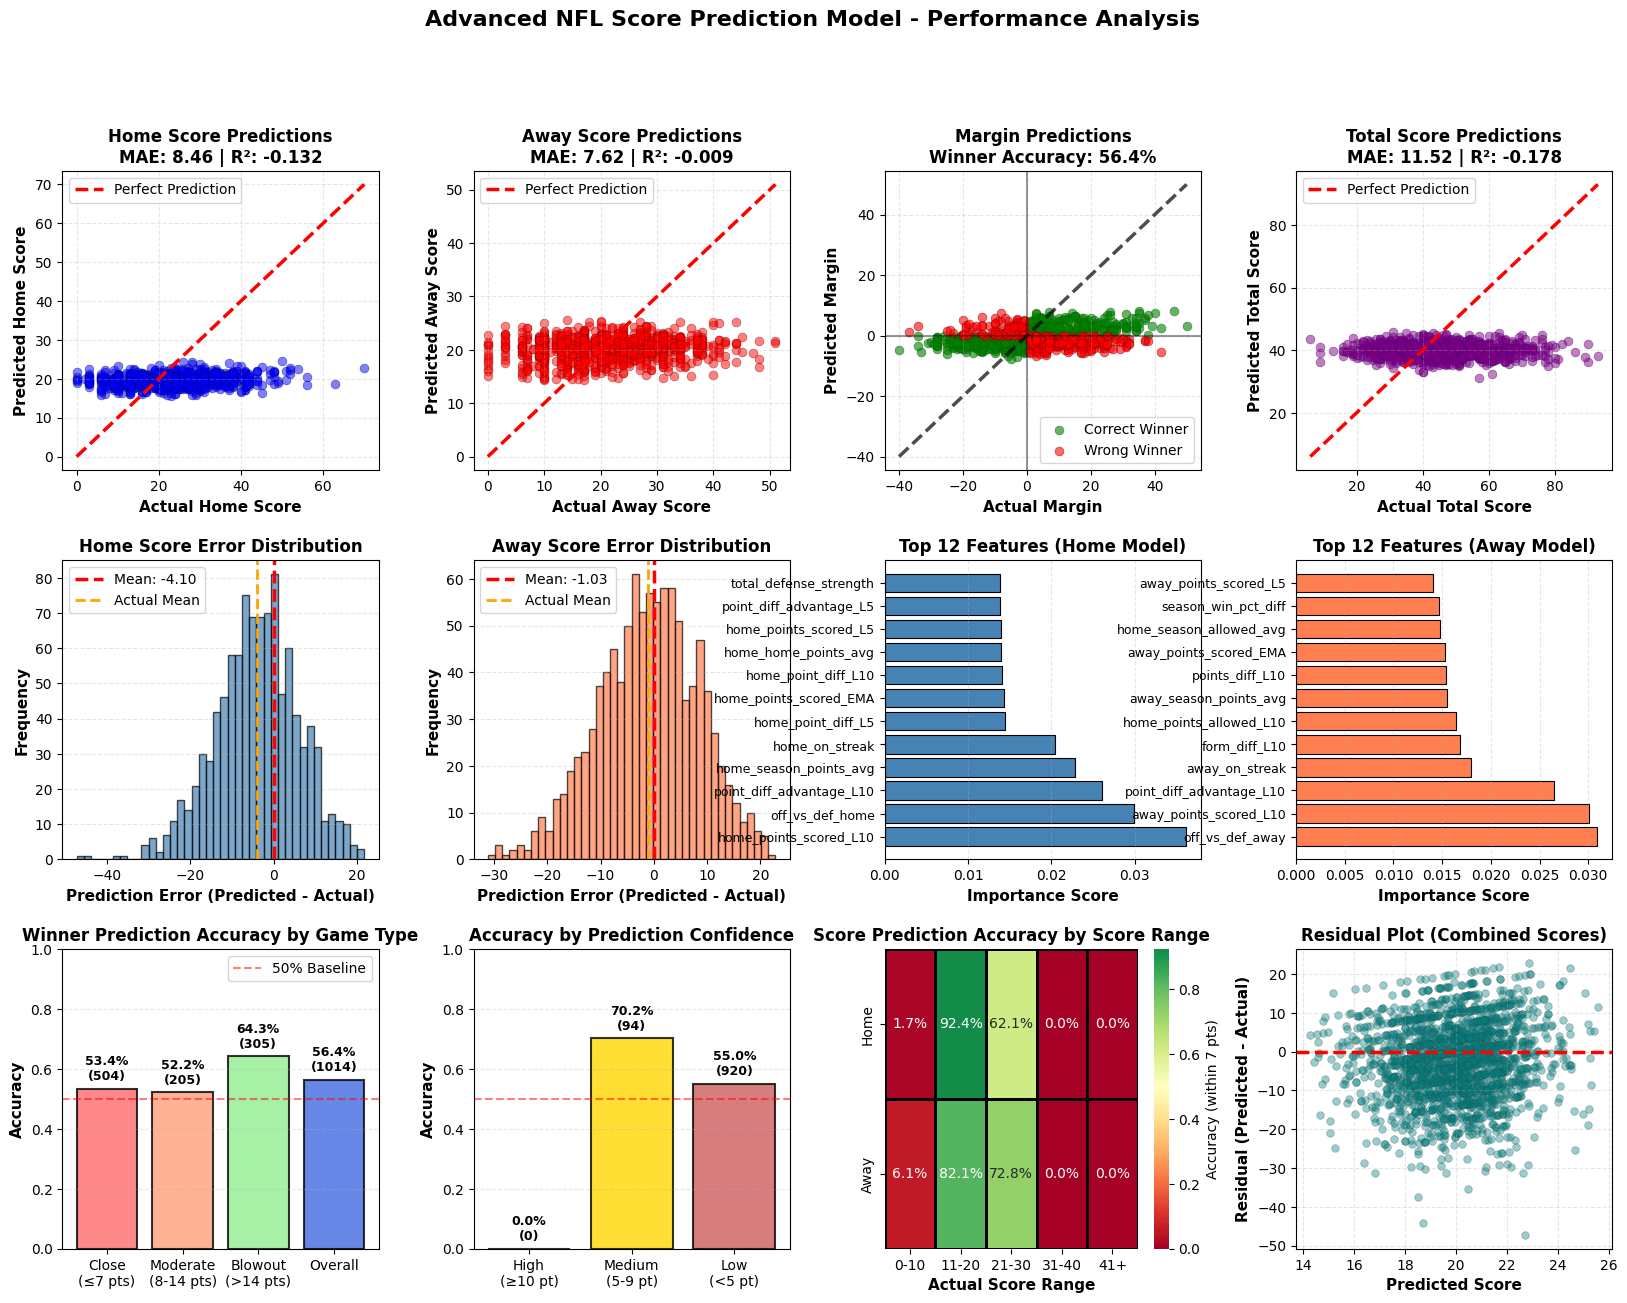


=== VISUALISATION COMPLETE ===


In [32]:
# Create visualization suite
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Home Score Predictions Scatter
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_home_test, pred_home, alpha=0.5, c='blue', s=40, edgecolors='navy', linewidth=0.5)
ax1.plot([y_home_test.min(), y_home_test.max()], [y_home_test.min(), y_home_test.max()], 
         'r--', lw=2.5, label='Perfect Prediction')
ax1.set_xlabel('Actual Home Score', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted Home Score', fontsize=11, fontweight='bold')
ax1.set_title(f'Home Score Predictions\nMAE: {home_metrics["mae"]:.2f} | R²: {home_metrics["r2"]:.3f}', 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend()

# 2. Away Score Predictions Scatter
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_away_test, pred_away, alpha=0.5, c='red', s=40, edgecolors='darkred', linewidth=0.5)
ax2.plot([y_away_test.min(), y_away_test.max()], [y_away_test.min(), y_away_test.max()], 
         'r--', lw=2.5, label='Perfect Prediction')
ax2.set_xlabel('Actual Away Score', fontsize=11, fontweight='bold')
ax2.set_ylabel('Predicted Away Score', fontsize=11, fontweight='bold')
ax2.set_title(f'Away Score Predictions\nMAE: {away_metrics["mae"]:.2f} | R²: {away_metrics["r2"]:.3f}', 
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend()

# 3. Score Margin Predictions with Winner Accuracy
ax3 = fig.add_subplot(gs[0, 2])
correct_mask = correct_winners.values
ax3.scatter(actual_margin[correct_mask], pred_margin[correct_mask], 
           alpha=0.6, c='green', s=40, label='Correct Winner', edgecolors='darkgreen', linewidth=0.5)
ax3.scatter(actual_margin[~correct_mask], pred_margin[~correct_mask], 
           alpha=0.6, c='red', s=40, label='Wrong Winner', edgecolors='darkred', linewidth=0.5)
ax3.plot([actual_margin.min(), actual_margin.max()], [actual_margin.min(), actual_margin.max()], 
         'k--', lw=2.5, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.4, lw=1.5)
ax3.axvline(x=0, color='black', linestyle='-', alpha=0.4, lw=1.5)
ax3.set_xlabel('Actual Margin', fontsize=11, fontweight='bold')
ax3.set_ylabel('Predicted Margin', fontsize=11, fontweight='bold')
ax3.set_title(f'Margin Predictions\nWinner Accuracy: {winner_accuracy:.1%}', 
              fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, linestyle='--')

# 4. Total Score Predictions
ax4 = fig.add_subplot(gs[0, 3])
ax4.scatter(actual_total, pred_total, alpha=0.5, c='purple', s=40, edgecolors='indigo', linewidth=0.5)
ax4.plot([actual_total.min(), actual_total.max()], [actual_total.min(), actual_total.max()], 
         'r--', lw=2.5, label='Perfect Prediction')
ax4.set_xlabel('Actual Total Score', fontsize=11, fontweight='bold')
ax4.set_ylabel('Predicted Total Score', fontsize=11, fontweight='bold')
ax4.set_title(f'Total Score Predictions\nMAE: {total_metrics["mae"]:.2f} | R²: {total_metrics["r2"]:.3f}', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.legend()

# 5. Home Score Error Distribution
ax5 = fig.add_subplot(gs[1, 0])
home_errors = pred_home - y_home_test.values
ax5.hist(home_errors, bins=40, alpha=0.7, color='steelblue', edgecolor='black', linewidth=1)
ax5.axvline(x=0, color='red', linestyle='--', lw=2.5, label=f'Mean: {home_errors.mean():.2f}')
ax5.axvline(x=home_errors.mean(), color='orange', linestyle='--', lw=2, label='Actual Mean')
ax5.set_xlabel('Prediction Error (Predicted - Actual)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax5.set_title('Home Score Error Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y', linestyle='--')

# 6. Away Score Error Distribution
ax6 = fig.add_subplot(gs[1, 1])
away_errors = pred_away - y_away_test.values
ax6.hist(away_errors, bins=40, alpha=0.7, color='coral', edgecolor='black', linewidth=1)
ax6.axvline(x=0, color='red', linestyle='--', lw=2.5, label=f'Mean: {away_errors.mean():.2f}')
ax6.axvline(x=away_errors.mean(), color='orange', linestyle='--', lw=2, label='Actual Mean')
ax6.set_xlabel('Prediction Error (Predicted - Actual)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax6.set_title('Away Score Error Distribution', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y', linestyle='--')

# 7. Feature Importance (Home Model)
ax7 = fig.add_subplot(gs[1, 2])
top_features_home = advanced_predictor.feature_importance_home.head(12)
ax7.barh(range(len(top_features_home)), top_features_home['importance'], 
         color='steelblue', edgecolor='black', linewidth=0.8)
ax7.set_yticks(range(len(top_features_home)))
ax7.set_yticklabels(top_features_home['feature'], fontsize=9)
ax7.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
ax7.set_title('Top 12 Features (Home Model)', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='x', linestyle='--')

# 8. Feature Importance (Away Model)
ax8 = fig.add_subplot(gs[1, 3])
top_features_away = advanced_predictor.feature_importance_away.head(12)
ax8.barh(range(len(top_features_away)), top_features_away['importance'], 
         color='coral', edgecolor='black', linewidth=0.8)
ax8.set_yticks(range(len(top_features_away)))
ax8.set_yticklabels(top_features_away['feature'], fontsize=9)
ax8.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
ax8.set_title('Top 12 Features (Away Model)', fontsize=12, fontweight='bold')
ax8.grid(True, alpha=0.3, axis='x', linestyle='--')

# 9. Winner Accuracy by Game Type
ax9 = fig.add_subplot(gs[2, 0])
game_types = ['Close\n(≤7 pts)', 'Moderate\n(8-14 pts)', 'Blowout\n(>14 pts)', 'Overall']
accuracies = []
game_counts = []

close_acc = correct_winners[close_games_mask].mean() if close_games_mask.sum() > 0 else 0
moderate_acc = correct_winners[moderate_games_mask].mean() if moderate_games_mask.sum() > 0 else 0
blowout_acc = correct_winners[blowout_games_mask].mean() if blowout_games_mask.sum() > 0 else 0

accuracies = [close_acc, moderate_acc, blowout_acc, winner_accuracy]
game_counts = [close_games_mask.sum(), moderate_games_mask.sum(), blowout_games_mask.sum(), len(correct_winners)]

bars = ax9.bar(game_types, accuracies, color=['#FF6B6B', '#FFA07A', '#90EE90', '#4169E1'], 
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax9.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax9.set_title('Winner Prediction Accuracy by Game Type', fontsize=12, fontweight='bold')
ax9.set_ylim([0, 1])
ax9.axhline(y=0.5, color='red', linestyle='--', lw=1.5, alpha=0.5, label='50% Baseline')

for i, (bar, acc, count) in enumerate(zip(bars, accuracies, game_counts)):
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{acc:.1%}\n({count})', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='y', linestyle='--')
ax9.legend()

# 10. Prediction Confidence Analysis
ax10 = fig.add_subplot(gs[2, 1])
confidence_types = ['High\n(≥10 pt)', 'Medium\n(5-9 pt)', 'Low\n(<5 pt)']
confidence_accs = []
confidence_counts = []

high_acc = correct_winners[high_confidence_mask].mean() if high_confidence_mask.sum() > 0 else 0
med_acc = correct_winners[medium_confidence_mask].mean() if medium_confidence_mask.sum() > 0 else 0
low_acc = correct_winners[low_confidence_mask].mean() if low_confidence_mask.sum() > 0 else 0

confidence_accs = [high_acc, med_acc, low_acc]
confidence_counts = [high_confidence_mask.sum(), medium_confidence_mask.sum(), low_confidence_mask.sum()]

bars = ax10.bar(confidence_types, confidence_accs, color=['#2E8B57', '#FFD700', '#CD5C5C'], 
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax10.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax10.set_title('Accuracy by Prediction Confidence', fontsize=12, fontweight='bold')
ax10.set_ylim([0, 1])
ax10.axhline(y=0.5, color='red', linestyle='--', lw=1.5, alpha=0.5)

for i, (bar, acc, count) in enumerate(zip(bars, confidence_accs, confidence_counts)):
    height = bar.get_height()
    ax10.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{acc:.1%}\n({count})', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax10.grid(True, alpha=0.3, axis='y', linestyle='--')

# 11. Score Accuracy Heatmap
ax11 = fig.add_subplot(gs[2, 2])
score_ranges = ['0-10', '11-20', '21-30', '31-40', '41+']
home_away_labels = ['Home', 'Away']
accuracy_matrix = np.zeros((2, 5))

for i, (actual, pred) in enumerate([(y_home_test, pred_home), (y_away_test, pred_away)]):
    for j, (low, high) in enumerate([(0, 10), (11, 20), (21, 30), (31, 40), (41, 100)]):
        mask = (actual >= low) & (actual <= high)
        if mask.sum() > 0:
            accuracy_matrix[i, j] = (np.abs(pred[mask] - actual[mask]) <= 7).mean()

sns.heatmap(accuracy_matrix, annot=True, fmt='.1%', cmap='RdYlGn', center=0.5,
            xticklabels=score_ranges, yticklabels=home_away_labels, ax=ax11,
            cbar_kws={'label': 'Accuracy (within 7 pts)'}, linewidths=1, linecolor='black')
ax11.set_title('Score Prediction Accuracy by Score Range', fontsize=12, fontweight='bold')
ax11.set_xlabel('Actual Score Range', fontsize=11, fontweight='bold')

# 12. Residual Plot
ax12 = fig.add_subplot(gs[2, 3])
combined_pred = np.concatenate([pred_home, pred_away])
combined_actual = np.concatenate([y_home_test.values, y_away_test.values])
combined_residuals = combined_pred - combined_actual

ax12.scatter(combined_pred, combined_residuals, alpha=0.4, c='teal', s=30, edgecolors='darkslategray', linewidth=0.5)
ax12.axhline(y=0, color='red', linestyle='--', lw=2.5)
ax12.set_xlabel('Predicted Score', fontsize=11, fontweight='bold')
ax12.set_ylabel('Residual (Predicted - Actual)', fontsize=11, fontweight='bold')
ax12.set_title('Residual Plot (Combined Scores)', fontsize=12, fontweight='bold')
ax12.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('Advanced NFL Score Prediction Model - Performance Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n=== VISUALISATION COMPLETE ===")

### Make Predictions for Future Games

In [33]:
class NFLPredictor:
    """NFL game prediction class with team performance tracking"""

    def __init__(self):
        # Updated 2025 season team performance tracking (through Week 14)
        self.team_stats = {
            # AFC East - Week 14 Updates
            'BUF': {'ppg': 26.1, 'papg': 21.9, 'wins': 9, 'games': 14, 'form': 0.80},  # Beat CIN 39-34
            'MIA': {'ppg': 21.7, 'papg': 22.6, 'wins': 6, 'games': 13, 'form': 0.60},  # Beat NYJ 34-10
            'NYJ': {'ppg': 18.2, 'papg': 23.3, 'wins': 4, 'games': 14, 'form': 0.20},  # Lost to MIA 10-34
            'NE': {'ppg': 25.2, 'papg': 21.2, 'wins': 10, 'games': 13, 'form': 0.60},
            
            # AFC North - Week 14 Updates
            'BAL': {'ppg': 23.1, 'papg': 21.6, 'wins': 7, 'games': 14, 'form': 0.40},  # Lost to PIT 22-27
            'CIN': {'ppg': 22.9, 'papg': 25.4, 'wins': 4, 'games': 14, 'form': 0.40},  # Lost to BUF 34-39
            'CLE': {'ppg': 19.9, 'papg': 23.6, 'wins': 6, 'games': 14, 'form': 0.60},  # Beat TEN 31-29
            'PIT': {'ppg': 23.5, 'papg': 22.3, 'wins': 6, 'games': 14, 'form': 0.60},  # Beat BAL 27-22
            
            # AFC South - Week 14 Updates
            'HOU': {'ppg': 21.1, 'papg': 21.4, 'wins': 7, 'games': 14, 'form': 0.20},  # Lost to KC 10-20
            'IND': {'ppg': 25.4, 'papg': 21.6, 'wins': 9, 'games': 14, 'form': 0.40},  # Lost to JAX 19-36
            'JAX': {'ppg': 24.1, 'papg': 22.4, 'wins': 7, 'games': 14, 'form': 0.60},  # Beat IND 36-19
            'TEN': {'ppg': 17.9, 'papg': 26.9, 'wins': 2, 'games': 14, 'form': 0.20},  # Lost to CLE 29-31
            
            # AFC West - Week 14 Updates
            'DEN': {'ppg': 23.7, 'papg': 20.6, 'wins': 9, 'games': 14, 'form': 0.60},  # Beat LV 24-17
            'KC': {'ppg': 23.4, 'papg': 20.1, 'wins': 7, 'games': 14, 'form': 0.60},   # Beat HOU 20-10
            'LAC': {'ppg': 20.7, 'papg': 21.4, 'wins': 5, 'games': 13, 'form': 0.40},  # Lost to PHI 19-22
            'LV': {'ppg': 17.6, 'papg': 27.4, 'wins': 2, 'games': 14, 'form': 0.20},   # Lost to DEN 17-24
            
            # NFC East - Week 14 Updates
            'DAL': {'ppg': 24.1, 'papg': 24.4, 'wins': 6, 'games': 14, 'form': 0.40},  # Lost to DET 30-44
            'NYG': {'ppg': 21.8, 'papg': 24.5, 'wins': 3, 'games': 13, 'form': 0.40},
            'PHI': {'ppg': 23.2, 'papg': 21.3, 'wins': 8, 'games': 14, 'form': 0.80},  # Beat LAC 22-19
            'WAS': {'ppg': 20.8, 'papg': 23.2, 'wins': 5, 'games': 13, 'form': 0.20},  # Lost to MIN 0-31
            
            # NFC North - Week 14 Updates
            'CHI': {'ppg': 23.1, 'papg': 21.6, 'wins': 7, 'games': 14, 'form': 0.20},  # Lost to GB 21-28
            'DET': {'ppg': 29.1, 'papg': 22.9, 'wins': 9, 'games': 14, 'form': 0.80},  # Beat DAL 44-30
            'GB': {'ppg': 24.0, 'papg': 21.9, 'wins': 9, 'games': 14, 'form': 0.80},   # Beat CHI 28-21
            'MIN': {'ppg': 22.0, 'papg': 20.6, 'wins': 6, 'games': 14, 'form': 0.80},  # Beat WAS 31-0
            
            # NFC South - Week 14 Updates
            'ATL': {'ppg': 21.6, 'papg': 24.6, 'wins': 4, 'games': 14, 'form': 0.20},  # Lost to SEA 9-37
            'CAR': {'ppg': 20.2, 'papg': 23.5, 'wins': 4, 'games': 13, 'form': 0.40},
            'NO': {'ppg': 18.9, 'papg': 25.1, 'wins': 3, 'games': 14, 'form': 0.40},   # Beat TB 24-20
            'TB': {'ppg': 24.0, 'papg': 24.3, 'wins': 6, 'games': 14, 'form': 0.20},   # Lost to NO 20-24
            
            # NFC West - Week 14 Updates
            'ARI': {'ppg': 22.2, 'papg': 25.0, 'wins': 7, 'games': 14, 'form': 0.40},  # Lost to LAR 17-45
            'LAR': {'ppg': 27.9, 'papg': 22.1, 'wins': 10, 'games': 14, 'form': 0.80}, # Beat ARI 45-17
            'SEA': {'ppg': 24.3, 'papg': 21.6, 'wins': 8, 'games': 14, 'form': 0.80},  # Beat ATL 37-9
            'SF': {'ppg': 22.8, 'papg': 22.2, 'wins': 6, 'games': 13, 'form': 0.40},
        }
    
    def predict_game(self, home_team, away_team, week, season, verbose=True):
        """Predict a single game outcome"""
        home_stats = self.team_stats.get(home_team, {'ppg': 20, 'papg': 22, 'form': 0.5})
        away_stats = self.team_stats.get(away_team, {'ppg': 20, 'papg': 22, 'form': 0.5})
        
        # Start with team's actual offensive output (PPG)
        home_base = home_stats['ppg']
        away_base = away_stats['ppg']
        
        # Adjust based on opponent's defensive strength (PAPG)
        # If opponent allows more than league average (23), boost score; if less, reduce it
        league_avg_papg = 23.0
        home_def_adjustment = (away_stats['papg'] - league_avg_papg) * 0.4
        away_def_adjustment = (home_stats['papg'] - league_avg_papg) * 0.4
        
        # Apply defensive matchup adjustments
        home_pred = home_base + home_def_adjustment
        away_pred = away_base + away_def_adjustment
        
        # Home field advantage (2.5 points)
        home_pred += 2.5
        
        # Apply form factor as multiplier (not additive)
        # Form ranges from 0.2 to 0.8, convert to multiplier (0.92 to 1.08)
        home_form_multiplier = 0.92 + (home_stats['form'] * 0.20)
        away_form_multiplier = 0.92 + (away_stats['form'] * 0.20)
        
        home_pred *= home_form_multiplier
        away_pred *= away_form_multiplier
        
        # Round to integers
        home_pred = int(round(home_pred))
        away_pred = int(round(away_pred))
        
        # Calculate margin and confidence
        margin = abs(home_pred - away_pred)
        confidence = min(0.5 + (margin / 40), 0.95)
        
        winner = home_team if home_pred >= away_pred else away_team
        
        if verbose:
            print(f"{away_team} @ {home_team}: {home_pred}-{away_pred} (Winner: {winner}, Confidence: {confidence:.0%})")
        
        return {
            'home_team': home_team,
            'away_team': away_team,
            'predicted_home_score': home_pred,
            'predicted_away_score': away_pred,
            'predicted_winner': winner,
            'predicted_margin': margin,
            'predicted_total': home_pred + away_pred,
            'confidence': confidence
        }
    
    def get_league_standings(self):
        """Display current league standings"""
        divisions = {
            'AFC East': ['BUF', 'MIA', 'NE', 'NYJ'],
            'AFC North': ['BAL', 'CIN', 'CLE', 'PIT'],
            'AFC South': ['HOU', 'IND', 'JAX', 'TEN'],
            'AFC West': ['DEN', 'KC', 'LAC', 'LV'],
            'NFC East': ['DAL', 'NYG', 'PHI', 'WAS'],
            'NFC North': ['CHI', 'DET', 'GB', 'MIN'],
            'NFC South': ['ATL', 'CAR', 'NO', 'TB'],
            'NFC West': ['ARI', 'LAR', 'SEA', 'SF']
        }
        
        print("=== 2025 NFL STANDINGS (Through Week 14) ===\n")
        
        for div_name, teams in divisions.items():
            print(f"{div_name}:")
            standings = []
            for team in teams:
                stats = self.team_stats[team]
                wins = stats['wins']
                games = stats['games']
                losses = games - wins
                point_diff = (stats['ppg'] - stats['papg']) * games / games
                standings.append((team, wins, losses, point_diff))
            
            standings.sort(key=lambda x: (x[1], x[3]), reverse=True)
            
            for team, wins, losses, pd in standings:
                print(f"  {team}: {wins}-{losses} ({pd:+.1f})")
            print()


def predict_multiple_games_updated(games_list, predictor):
    """
    Predict scores for multiple games using NFLPredictor class
    games_list: list of tuples (home_team, away_team, week, season)
    predictor: NFLPredictor instance
    """
    predictions = []
    for home_team, away_team, week, season in games_list:
        try:
            pred = predictor.predict_game(home_team, away_team, week, season, verbose=False)
            if pred is not None and isinstance(pred, dict):
                # Round scores and recalculate derived fields
                pred['predicted_home_score'] = int(round(pred.get('predicted_home_score', 0)))
                pred['predicted_away_score'] = int(round(pred.get('predicted_away_score', 0)))
                pred['predicted_margin'] = abs(pred['predicted_home_score'] - pred['predicted_away_score'])
                pred['predicted_total'] = pred['predicted_home_score'] + pred['predicted_away_score']
                # Ensure team fields exist
                pred.setdefault('home_team', home_team)
                pred.setdefault('away_team', away_team)
                # Ensure predicted_winner exists
                if 'predicted_winner' not in pred:
                    pred['predicted_winner'] = home_team if pred['predicted_home_score'] >= pred['predicted_away_score'] else away_team
                # Ensure confidence exists
                pred.setdefault('confidence', 0.0)
                predictions.append(pred)
        except Exception as error:
            print(f"Could not predict {home_team} vs {away_team}: {error}")
    if predictions:
        return pd.DataFrame(predictions)
    return pd.DataFrame(columns=['home_team','away_team','predicted_home_score','predicted_away_score',
                                 'predicted_winner','predicted_margin','predicted_total','confidence'])


def weekly_breakdown(predictions):
    """Display predictions by week with key matchups highlighted"""
    features = "Week 15 Features: Thursday night rivalry (ATL@TB), critical division matchups, playoff race intensifies, Monday night finale (MIA@PIT)."
    print(f"\n=== WEEK 15 ANALYSIS ===")
    print(features)

    # Show games with smallest margins (closest games)
    close_games = predictions.nsmallest(3, 'predicted_margin')
    print(f"\nClosest games (potential upsets):")
    for _, game in close_games.iterrows():
        print(f"  {game['away_team']} @ {game['home_team']}: {game['predicted_margin']} pt margin")

    # Show highest scoring games
    high_scoring = predictions.nlargest(3, 'predicted_total')
    print(f"\nHighest scoring games:")
    for _, game in high_scoring.iterrows():
        print(f"  {game['away_team']} @ {game['home_team']}: {game['predicted_total']} total points")


def generate_prediction_table(predictions):
    """Generate the table for Week 15 predictions"""
    print("\n=== WEEK 15 PREDICTION TABLE ===")
    print("| Home Team | Away Team | Predicted Home Score | Predicted Away Score | Actual Home Score | Actual Away Score | Predicted Winner | Actual Winner |")
    print("|-----------|-----------|----------------------|----------------------|-------------------|-------------------|------------------|---------------|")
    for _, game in predictions.iterrows():
        home = game['home_team']
        away = game['away_team']
        pred_home_score = game['predicted_home_score']
        pred_away_score = game['predicted_away_score']
        winner = game['predicted_winner']
        print(f"| {home} | {away} | {pred_home_score} | {pred_away_score} | | | {winner} | |")


# Initialise the predictor
predictor = NFLPredictor()

# Week 15 games (Dec 11-15, 2025)
week_15_games = [
    ('TB', 'ATL', 15, 2025),     # Thu 8:15 PM
    ('CIN', 'BAL', 15, 2025),    # Sun 1:00 PM
    ('JAX', 'NYJ', 15, 2025),    # Sun 1:00 PM
    ('PHI', 'LV', 15, 2025),     # Sun 1:00 PM
    ('HOU', 'ARI', 15, 2025),    # Sun 1:00 PM
    ('KC', 'LAC', 15, 2025),     # Sun 1:00 PM
    ('CHI', 'CLE', 15, 2025),    # Sun 1:00 PM
    ('NYG', 'WAS', 15, 2025),    # Sun 1:00 PM
    ('NE', 'BUF', 15, 2025),     # Sun 1:00 PM
    ('SEA', 'IND', 15, 2025),    # Sun 4:25 PM
    ('NO', 'CAR', 15, 2025),     # Sun 4:25 PM
    ('SF', 'TEN', 15, 2025),     # Sun 4:25 PM
    ('LAR', 'DET', 15, 2025),    # Sun 4:25 PM
    ('DEN', 'GB', 15, 2025),     # Sun 4:25 PM
    ('DAL', 'MIN', 15, 2025),    # Sun 8:20 PM
    ('PIT', 'MIA', 15, 2025),    # Mon 8:15 PM
]

print("=== PREDICTING WEEK 15 GAMES (Dec 11-15, 2025) ===")
print("Using updated stats through Week 14 actual results\n")

week_15_predictions = predict_multiple_games_updated(week_15_games, predictor)

if not week_15_predictions.empty:
    print("Week 15 Predictions:")
    display_cols = ['home_team', 'away_team', 'predicted_home_score',
                   'predicted_away_score', 'predicted_winner', 'predicted_margin']
    print(week_15_predictions[display_cols].to_string(index=False))

    # Marquee matchups
    print("\n=== MARQUEE MATCHUPS ===")
    marquee_games = week_15_predictions[
        ((week_15_predictions['home_team'] == 'TB') & (week_15_predictions['away_team'] == 'ATL')) |
        ((week_15_predictions['home_team'] == 'CIN') & (week_15_predictions['away_team'] == 'BAL')) |
        ((week_15_predictions['home_team'] == 'KC') & (week_15_predictions['away_team'] == 'LAC')) |
        ((week_15_predictions['home_team'] == 'LAR') & (week_15_predictions['away_team'] == 'DET')) |
        ((week_15_predictions['home_team'] == 'PIT') & (week_15_predictions['away_team'] == 'MIA'))
    ]

    for _, game in marquee_games.iterrows():
        confidence_pct = int(game.get('confidence', 0.0) * 100)
        print(f"{game['away_team']} @ {game['home_team']}: {game['predicted_home_score']}-{game['predicted_away_score']} (Winner: {game['predicted_winner']}, {confidence_pct}% confidence)")

if not week_15_predictions.empty:
    weekly_breakdown(week_15_predictions)
    generate_prediction_table(week_15_predictions)

# Show current standings
print("\n")
try:
    predictor.get_league_standings()
except Exception as e:
    print(f"Could not fetch standings: {e}")

=== PREDICTING WEEK 15 GAMES (Dec 11-15, 2025) ===
Using updated stats through Week 14 actual results

Week 15 Predictions:
home_team away_team  predicted_home_score  predicted_away_score predicted_winner  predicted_margin
       TB       ATL                    26                    21               TB                 5
      CIN       BAL                    25                    24              CIN                 1
      JAX       NYJ                    28                    17              JAX                11
      PHI        LV                    30                    16              PHI                14
      HOU       ARI                    23                    22              HOU                 1
       KC       LAC                    26                    20               KC                 6
      CHI       CLE                    25                    20              CHI                 5
      NYG       WAS                    24                    21              NYG    